# 01. Feature Exploration

This notebook explores the features generated by the analytics pipeline.
It connects to the `analyzers_features` table and provides statistical overviews and outlier analysis.

In [1]:
import sys
import os
# Ensure local utils can be imported regardless of CWD
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('./notebooks'))
sys.path.append(os.path.abspath('./analytics-pipeline/notebooks'))

from analytics_utils import get_db_client, query_to_df, setup_plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

setup_plotting()

Plotting environment setup complete.


## Configuration
Set the target network and processing date.

In [2]:
NETWORK = 'torus'  # e.g., 'torus', 'ethereum', 'bitcoin'
PROCESSING_DATE = '2025-04-18' # DATE of the pipeline run
WINDOW_DAYS = 120 # Window size used for feature calculation

## Data Loading
Fetch features from ClickHouse.

In [3]:
client = get_db_client(NETWORK)

query = f"""
SELECT *
FROM analyzers_features
WHERE processing_date = toDate('{PROCESSING_DATE}')
AND window_days = {WINDOW_DAYS}
"""

df = query_to_df(client, query)

# Convert decimals to floats for readability
from decimal import Decimal
for col in df.select_dtypes(include=['object']).columns:
    if len(df) > 0 and isinstance(df[col].iloc[0], (Decimal, type(None))):
        try:
            df[col] = df[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)
        except:
             pass

print(f"Loaded {len(df)} rows")
df.head(3)

Connecting to ClickHouse: localhost:8125 (DB: analytics_torus)
Connection successful!
Loaded 601 rows


,window_days,processing_date,address,degree_in,degree_out,degree_total,unique_counterparties,total_in_usd,total_out_usd,net_flow_usd,...,is_dormant_reactivated,unique_recipients_count,unique_senders_count,completeness_score,quality_score,outlier_score,confidence_score,first_activity_timestamp,last_activity_timestamp,_version
0,120,2025-04-18,5C4n8kb3mno7i8vQmqNgsQbwZozHvPyou8TAfZfZ7msTkS5f,0,3,2,2,0E-18,0E-18,0E-18,...,False,2,0,0.547945,0.683562,0.0,1.0,1736510016000,1736599904000,1763668912475772
1,120,2025-04-18,5C4s9HDfd95w9xfBae4zpmncEbQMfP1SsKCDHw9rf3heWgLt,5,0,1,1,0E-18,0E-18,0E-18,...,False,0,1,0.263889,0.484722,0.0,1.0,1734566400000,1744934400000,1763668912475783
2,120,2025-04-18,5C5Jpi5D3oAdfRh34FXWztNTpUaHKTWimQ6ExF94wXkrLo4q,0,1,1,1,0E-18,0E-18,0E-18,...,False,1,0,0.424658,0.597260,0.0,1.0,1736598960000,1736598960000,1763668912475791


## Feature Statistics
Review basic statistics for numerical features.

In [4]:
features_to_analyze = [
    'total_volume_usd', 'degree_total', 'pagerank',
    'flow_concentration', 'reciprocity_ratio', 'centrality_score'
]

# Convert Decimal columns to float for analysis if needed
for col in features_to_analyze:
    if col in df.columns:
        df[col] = df[col].astype(float)

df[features_to_analyze].describe()

,total_volume_usd,degree_total,pagerank,flow_concentration,reciprocity_ratio,centrality_score
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,3061.498841,1.484193,0.001664,-0.015148,0.004047,0.000666
std,15706.123944,1.983305,0.000383,0.105789,0.042286,0.000155
min,0.000000,1.000000,0.001568,-0.996833,0.000000,0.000627
25%,0.000000,1.000000,0.001568,0.000000,0.000000,0.000627
50%,0.000000,1.000000,0.001568,0.000000,0.000000,0.000627
75%,0.000000,1.000000,0.001568,0.000000,0.000000,0.000627
max,148212.506612,32.000000,0.004290,0.000000,0.500000,0.001716


## Distributions
Visualizing key feature distributions.

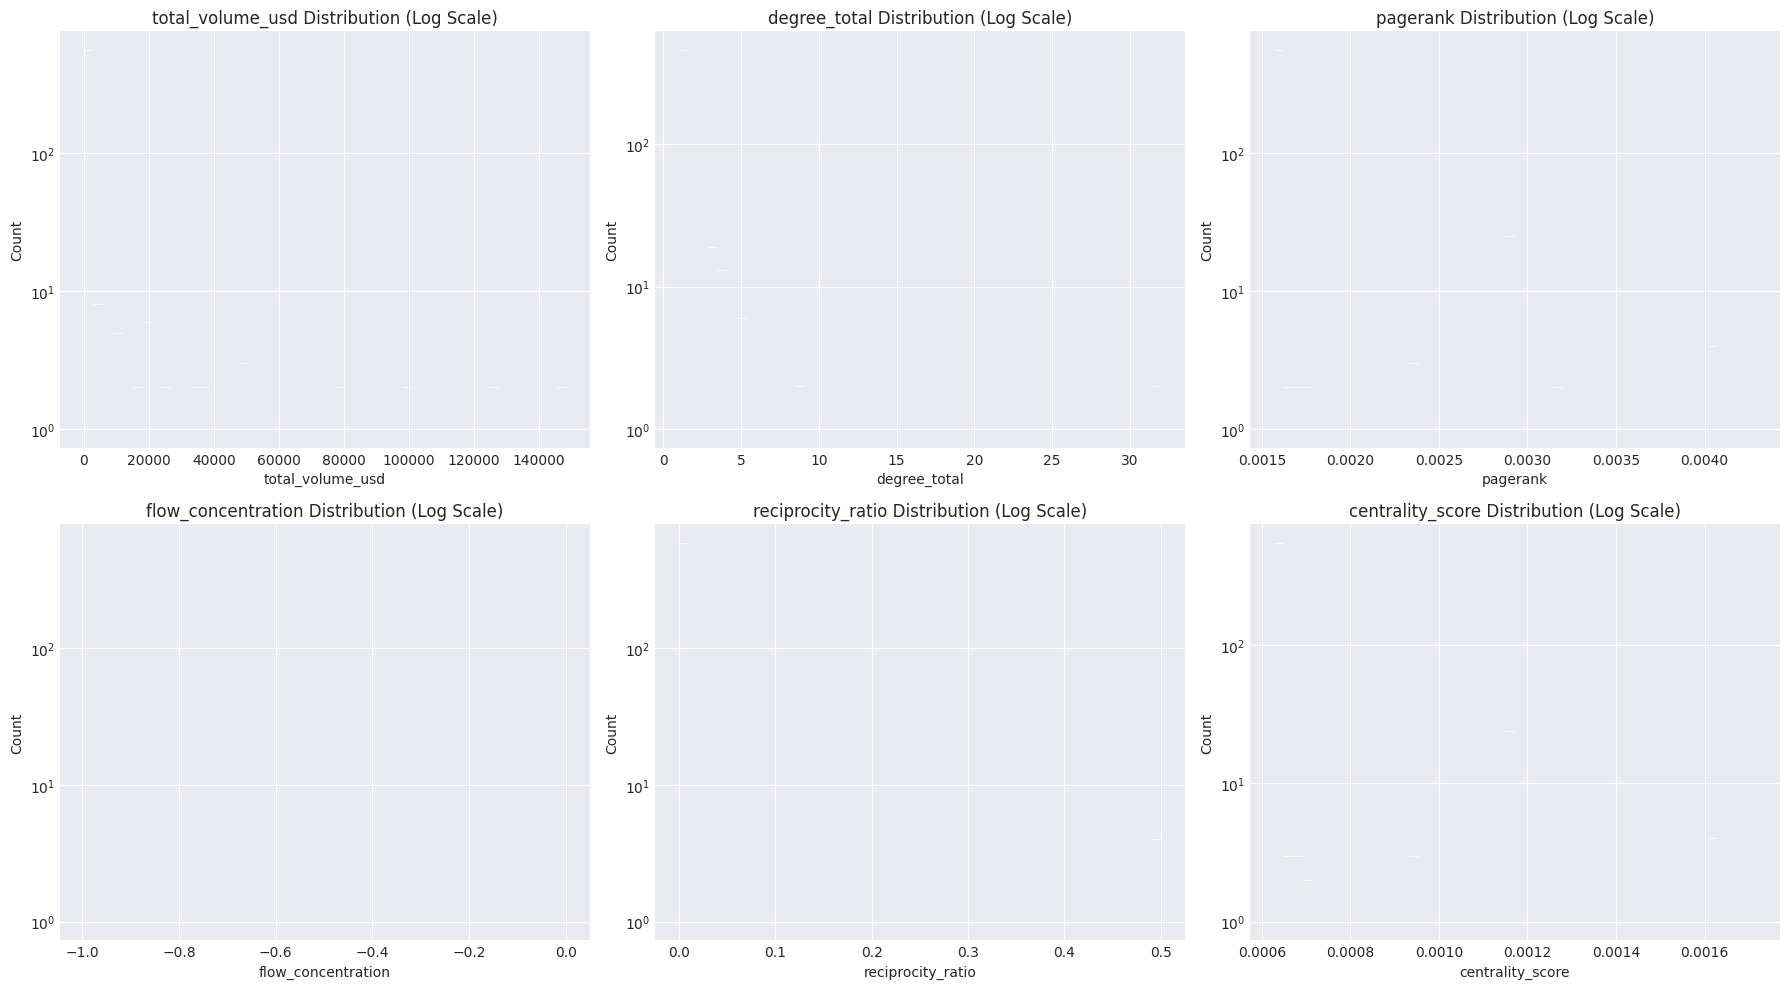

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(features_to_analyze):
    if col in df.columns:
        sns.histplot(df[col], bins=50, ax=axes[i], log_scale=(False, True))
        axes[i].set_title(f'{col} Distribution (Log Scale)')

plt.tight_layout()
plt.show()

## Correlations
Identify relationships between features.

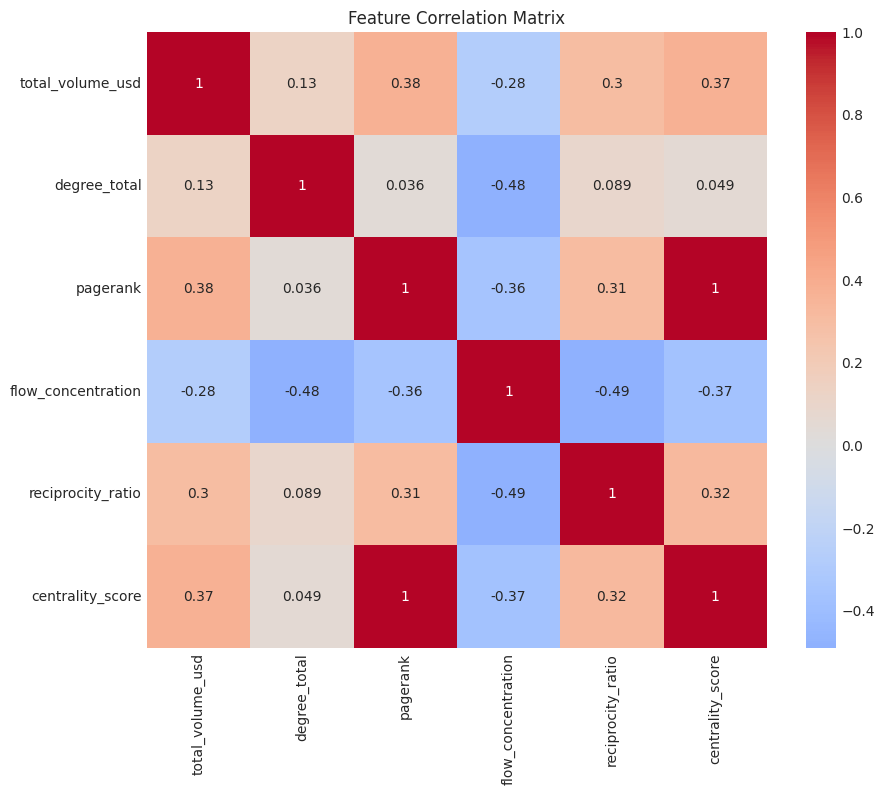

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[features_to_analyze].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

## Top Risk Addresses
Identifying potential high-risk actors based on centrality and volume.

In [7]:
# Filter for high-risk candidates
high_risk = df.sort_values('centrality_score', ascending=False).head(20)

display_cols = ['address', 'centrality_score', 'pagerank', 'total_volume_usd', 'degree_total']
high_risk[display_cols]

,address,centrality_score,pagerank,total_volume_usd,degree_total
381,5Fk3whq9Fr7yhMfXVMuokMprdPn3PMwkBDGcTG9Cc5m3GMgk,0.001716,0.004290,4219.977992,1.0
568,5HPLYyHnMPPJvvibY87gkCRJaZrrjfKVUWS1DcjB86dquy5i,0.001693,0.004233,49404.168871,2.0
371,5FeyBfmMovFsvuL9svRvCXMToz9kvx2PJsdARCMbp9WDStE7,0.001615,0.004033,15.051600,2.0
190,5DuxzHBr6KActaDNNbar5fsbeRqE2HypDL6JsiPvsHbjze2W,0.001613,0.004033,1601.266514,1.0
241,5EZ2hdey8S3ML6sWUhhV4ecV5Aq7esvUvtZvggq7eFwGh1oX,0.001613,0.004033,44463.751622,1.0
531,5H5YG65hSs7yzkichTLpuLfYbuvJ3kcKziBEGHiLGAjK4VyC,0.001613,0.004033,50070.929768,1.0
36,5CSPN5CCbxjEVyAjDqzdaerMxMAbkcex7KMME7vmFWxDXfLb,0.001490,0.003199,22448.199423,9.0
80,5Cqsa5VMGJZfvbJDT6Ybymm9EFT829C9RqzZX5QwCLJSqSdY,0.001259,0.003148,3402.445982,2.0
212,5EAjgxsnzMDiEkXjCwYiv4R5UGHdH8rgFnyqjXzBtS71vtMe,0.001204,0.003011,2773.869489,2.0
364,5FbdJn2huDQXi5htanuefe571ZxyiuELRjxQELM7XugTPtHr,0.001174,0.002900,127688.498416,4.0
